In [674]:
#Import Librarires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import datetime

In [675]:
users = pd.read_csv('takehome_users.csv', encoding='latin-1')
engage = pd.read_csv('takehome_user_engagement.csv')

In [676]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [677]:
engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


# Creating Adopted User label from the loaded engage dataframe

In [678]:
#check for missing values 
engage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


Good! There are no missing values. 

In [679]:
#convert to datetime format
engage['time_stamp'] = pd.to_datetime(engage['time_stamp'])

In [680]:
#set time_step as the index 
engage = engage.set_index('time_stamp')

In [681]:
engage.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [682]:
#check how many users and how many logins
print('There were {} users and {} total logins'.format(engage['user_id'].nunique(), len(engage)))

There were 8823 users and 207917 total logins


In [683]:
def label_adopted(x):    
    "takes a users input and returns whether or not they have been active within any 7-day period"
    df_temp = engage.loc[engage['user_id'] == x] #select out rows of this user
    df_temp = df_temp.resample('D').mean().dropna() #resample to show if active in a day. .mean() is just of 1
    adopted = 0
    for i in range(len(df_temp)-2): #loop over active days till the second to last day
        if df_temp.index[i + 2] - df_temp.index[i] <= timedelta(days=7): # difference between every 1st and 3rd day
            adopted = 1
            break
        else:
            adopted = 0
    return adopted

In [684]:
#apply to user df to label users as adopted=true 
users['adopted_user'] = users['object_id'].apply(label_adopted)

In [685]:
print(sum(users['adopted_user']))
print(sum(users.adopted_user)/len(users.adopted_user))

1656
0.138


In [686]:
print('There were {} adopted users out of {} users'.format(sum(users.adopted_user), len(users.adopted_user)))

There were 1656 adopted users out of 12000 users


# More Data Wrangling

Check for missing values. 

In [687]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
 10  adopted_user                12000 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 1.0+ MB


Two columns has missing values (last_session_creation_time and invited_by_user_id)

In [688]:
users.invited_by_user_id = users.invited_by_user_id.fillna(0)

Converting users dataframe to datetime format

In [689]:
#convert to datetime format
users['creation_time'] = pd.to_datetime(users['creation_time'])

#last_session_creation_time is a unix time stamp, so use map to convert to datetime
users['last_session_creation_time'] = users['last_session_creation_time'].map(lambda data: 
                                    datetime.datetime.fromtimestamp(int(data)).strftime('%Y-%m-%d %H:%M:%S'),
                                                                              na_action='ignore')

create usage length by subtracting last_session_creation_time and creation_time

In [690]:
#set to datetime
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'])
#subtract to find time active
users['usage_length'] = users['last_session_creation_time'] - users['creation_time']
#change seconds instead of days to make the time differences more distinct
users['usage_length'] = [x.total_seconds() for x in users['usage_length']]

Remove columns that won't be useful in our model

In [691]:
users_df = users.iloc[:,4:]
users_df = users_df.drop('last_session_creation_time', axis=1)
users_df['usage_length'] = users_df['usage_length'].fillna(0)

Using sklearn.preprocessing.LabelEncoder we can engineer categorical labels for each categorical feature.

In [692]:
from sklearn.preprocessing import LabelEncoder

gle = LabelEncoder()
creation_labels = gle.fit_transform(users['creation_source'])
users_df.creation_source = creation_labels

org_id_labels = gle.fit_transform(users['org_id'])
users_df.org_id = org_id_labels

invited_labels = gle.fit_transform(users['invited_by_user_id'])
users_df.org_id = invited_labels

In [693]:
users_df.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,usage_length
0,0,1,0,2325,10803.0,0,-25200.0
1,1,0,0,56,316.0,1,11725200.0
2,1,0,0,298,1525.0,0,-25200.0
3,0,0,0,1104,5151.0,0,61200.0
4,0,0,0,1127,5240.0,0,403200.0


# Analysis/Modeling

We will use RandomForestClassifier since we have a mixture of categorical and numerical data as well as a small sample size and feature set. 

In [694]:
from sklearn.model_selection import train_test_split

#set up data by seperating out the labels, then split for cross validation
data = users_df.drop('adopted_user', axis=1)
labels = users_df.adopted_user

X_train, y_train, X_test, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)

In [695]:
from sklearn.ensemble import RandomForestClassifier

#train and test classifier
rf = RandomForestClassifier(class_weight='balanced_subsample')

rf.fit(X_train, X_test)

rf.score(y_train, y_test)

0.9702020202020202

In [696]:
from sklearn.metrics import classification_report, confusion_matrix

#print out classification report and confusion matrix
y_pred = rf.predict(y_train)

print(classification_report(y_test, y_pred))

cm= confusion_matrix(y_test,y_pred)
print('confusion matrix:')
print(cm)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3407
           1       0.90      0.89      0.89       553

    accuracy                           0.97      3960
   macro avg       0.94      0.93      0.94      3960
weighted avg       0.97      0.97      0.97      3960

confusion matrix:
[[3352   55]
 [  63  490]]


# Feature Importance

In [697]:
#make a df that displays the cofficients indexed by feature name
feature_importance = pd.DataFrame()
feature_importance['coef'] = rf.feature_importances_
feature_importance = feature_importance.set_index(data.columns)
feature_importance.coef.nlargest(10)

usage_length                  0.935358
invited_by_user_id            0.024042
org_id                        0.023342
creation_source               0.011321
opted_in_to_mailing_list      0.003303
enabled_for_marketing_drip    0.002634
Name: coef, dtype: float64

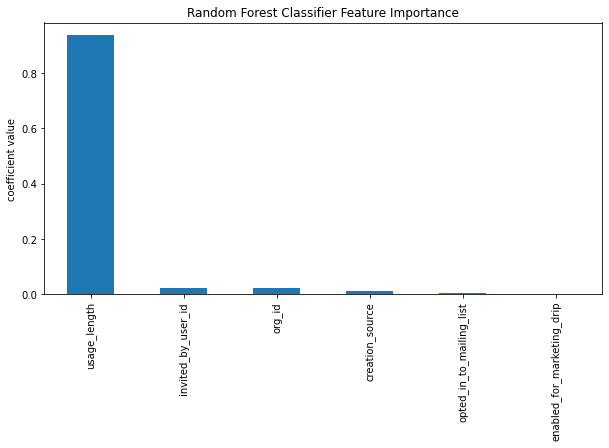

In [698]:
#plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
(feature_importance['coef']).nlargest(10).plot(kind='bar', x=feature_importance.index)
plt.title('Random Forest Classifier Feature Importance')
plt.ylabel('coefficient value')
plt.show()

In [699]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

In [700]:
adopted = feature_df.usage_length.loc[feature_df['adopted_user'] == 1]
not_adopted = feature_df.usage_length.loc[feature_df['adopted_user'] == 0]

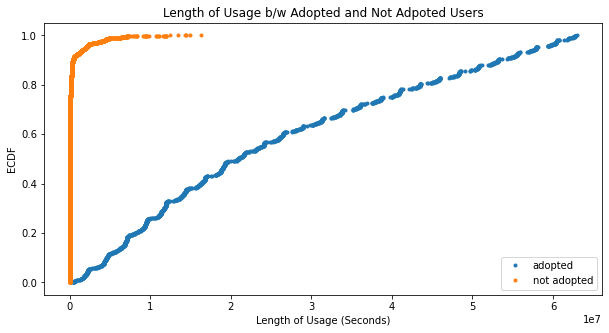

In [701]:
%matplotlib inline
plt.figure(figsize=(10,5))

x_active, y_active = ecdf(adopted)
x_inactive, y_inactive = ecdf(not_adopted)

plt.plot(x_active, y_active, marker='.', linestyle='none')
plt.plot(x_inactive, y_inactive, marker='.', linestyle='none')
plt.title('Length of Usage b/w Adopted and Not Adpoted Users')
plt.xlabel('Length of Usage (Seconds)')
plt.ylabel('ECDF')
plt.legend(['adopted', 'not adopted'])
plt.show()